In [20]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
import torch
import torchvision.transforms.functional as FT
from PIL import Image
import cv2
import os
import math
from torchvision.ops.boxes import box_iou
from collections import defaultdict
# http://www.robots.ox.ac.uk/~vgg/software/via/via-1.0.6.html

In [21]:
def process_bbox(df):
    df['bbox'] = df['region_shape_attributes'].apply(lambda x: eval(x))
    df['x'] = df['bbox'].apply(lambda x: x['x'])
    df['y'] = df['bbox'].apply(lambda x: x['y'])
    df['w'] = df['bbox'].apply(lambda x: x['width'])
    df['h'] = df['bbox'].apply(lambda x: x['height'])
    df['x'] = df['x'].astype(np.float)
    df['y'] = df['y'].astype(np.float)
    df['w'] = df['w'].astype(np.float)
    df['h'] = df['h'].astype(np.float)

    df.drop(columns=['bbox'], inplace=True)
    #     df.reset_index(drop=True)
    return df

In [32]:
csv_path = '/home/jake/PycharmProjects/balloon_detection/ballon_datasets/via_region_data_TEST_70.csv'

path ='/home/jake/PycharmProjects/balloon_detection/ballon_datasets/TEST/'
weight_path = '/home/jake/PycharmProjects/balloon_detection/weights/best_fasterrcnn_resnet50_fpn.pth'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"
input_size=300
df = pd.read_csv(csv_path)
df = process_bbox(df)
#image_id = '485227412_e335662bb5_b.jpg'
len(df)

67

# predict

In [33]:
def make_true_boxes(df,image_num):
    x = df[df['#filename'] == df['#filename'][image_num]]['x'].values
    y = df[df['#filename'] == df['#filename'][image_num]]['y'].values
    w = df[df['#filename'] == df['#filename'][image_num]]['w'].values
    h = df[df['#filename'] == df['#filename'][image_num]]['h'].values

    #print(x,y,w,h)
    true_boxes = []
    for i in range(len(x)):
        true_boxes.append([x[i], y[i], x[i] + w[i], y[i] + h[i]])
    return torch.tensor(true_boxes)

def make_true_boxes_new_scale(df,image_num):
    x = df[df['#filename'] == df['#filename'][image_num]]['x'].values
    y = df[df['#filename'] == df['#filename'][image_num]]['y'].values
    w = df[df['#filename'] == df['#filename'][image_num]]['w'].values
    h = df[df['#filename'] == df['#filename'][image_num]]['h'].values

    
    #print(x,y,w,h)
    true_boxes = []
    for i in range(len(x)):
        true_boxes.append([(x[i]*(input_size/w[i])),
                           y[i]*(input_size/h[i]),
                           (x[i]*(input_size/w[i])) + input_size, 
                           (y[i]*(input_size/h[i])) + input_size])
        
    true_boxes
    return torch.tensor(true_boxes)

def image_show(img_path,file_num,df,boxes,real,input_size):
    #print(df)
    img_path =path +df['#filename'][file_num]

    #print('img_path->',img_path)
    image_arr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_arr /= 255.0
    
    
    new_image = FT.to_tensor(image_arr)
    new_image = FT.to_pil_image(new_image)
    new_image = FT.resize(new_image, (input_size,input_size))
    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    #plt.imshow(new_image)
    
    #image_arr = new_image
    box_true=make_true_boxes(df,file_num)

    
    #print(image_arr.shape,image.shape)
    color = (0,255,0)
    thickness = 1
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    #print('boxes->',boxes)
    
    height = np.array(image_arr).shape[1]
    width = np.array(image_arr).shape[0]
    old_dims = torch.FloatTensor([width, height,width,height]).unsqueeze(0)
    new_dims =  torch.FloatTensor([input_size, input_size, input_size, input_size]).unsqueeze(0)
    #new_boxes=boxes/old_dims
    #print('old_dims->',old_dims)
    #print('new_dims->',new_dims)
    new_boxes = boxes * (new_dims/old_dims)
    #new_boxes = boxes

    #print('new_dims/old_dims->',new_dims/old_dims)
    #print('box_true->',box_true * (new_dims/old_dims))
    #print('new_boxes->',new_boxes)
    
    new_img = np.array(new_image)
    orig_img = np.array(image_arr)
    
    if real:
        boxs = boxes
        img = orig_img
        thickness = 3
        color = (0,0,255)
    else:
        boxs = new_boxes
        img = new_img
        thickness = 2
        color = (255,0,0)
    
    for box in boxs:
        #print('box->',box)
        #rem = 1
        cv2.rectangle(img,(int(box[0]),int(box[1])), ((int(box[2])), int(box[3])),color, thickness)
        #cv2.rectangle(orig_img,(0,400),(500,1000),color, thickness)
    #print('image->',np.array(orig_img).shape)
    ax.set_axis_off()
    ax.imshow(img)
    #plt.imshow(orig_img)

# original prediction

In [43]:
df['#filename'][36]

'dog5.jpg'

In [42]:
df[30:]

,#filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,x,y,w,h
30,imagekjkljkljls.jpg,4021,{},1,0,"{""name"":""rect"",""x"":30,""y"":5,""width"":163,""heigh...",{},30.0,5.0,163.0,166.0
31,imagefsdfsdfsds.jpg,3208,{},1,0,"{""name"":""rect"",""x"":37,""y"":3,""width"":160,""heigh...",{},37.0,3.0,160.0,217.0
32,imagdsfsdfsdfes.jpg,4522,{},1,0,"{""name"":""rect"",""x"":48,""y"":24,""width"":124,""heig...",{},48.0,24.0,124.0,132.0
33,dsfsdf.jpg,46826,{},1,0,"{""name"":""rect"",""x"":62,""y"":3,""width"":309,""heigh...",{},62.0,3.0,309.0,388.0
34,dsfdsfsd.jpg,4753,{},1,0,"{""name"":""rect"",""x"":35,""y"":4,""width"":167,""heigh...",{},35.0,4.0,167.0,213.0
35,dog5.jpg,4506,{},4,0,"{""name"":""rect"",""x"":39,""y"":16,""width"":64,""heigh...",{},39.0,16.0,64.0,72.0
36,dog5.jpg,4506,{},4,1,"{""name"":""rect"",""x"":122,""y"":26,""width"":66,""heig...",{},122.0,26.0,66.0,82.0
37,dog5.jpg,4506,{},4,2,"{""name"":""rect"",""x"":145,""y"":77,""width"":76,""heig...",{},145.0,77.0,76.0,106.0
38,dog5.jpg,4506,{},4,3,"{""name"":""rect"",""x"":54,""y"":54,""width"":87,""heigh...",{},54.0,54.0,87.0,89.0
39,dog4.jpg,14604,{},10,0,"{""name"":""rect"",""x"":21,""y"":56,""width"":26,""heigh...",{},21.0,56.0,26.0,26.0


In [37]:
len(df)

67

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

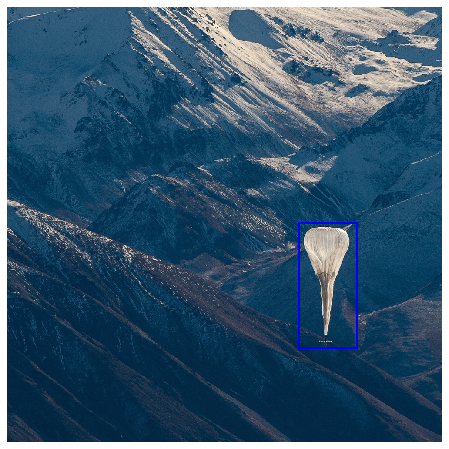

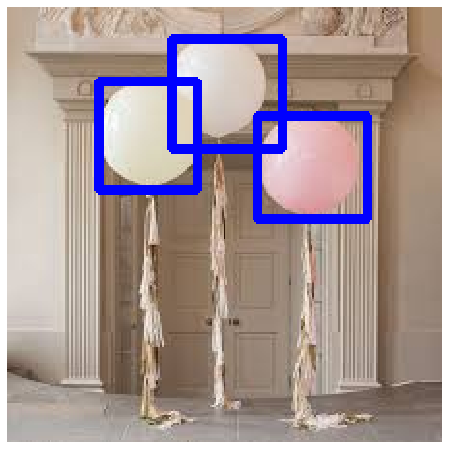

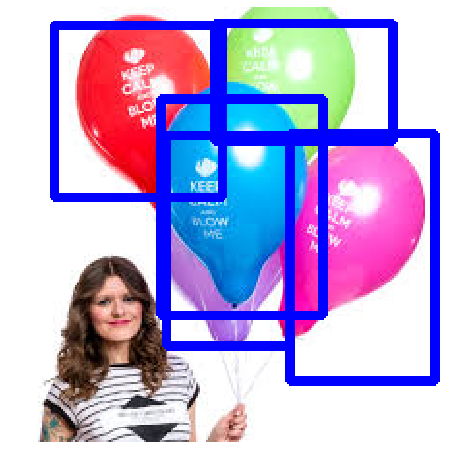

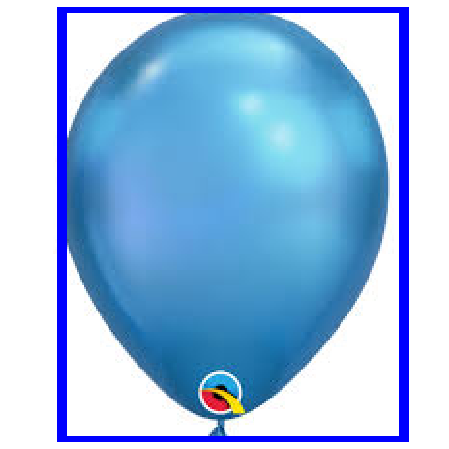

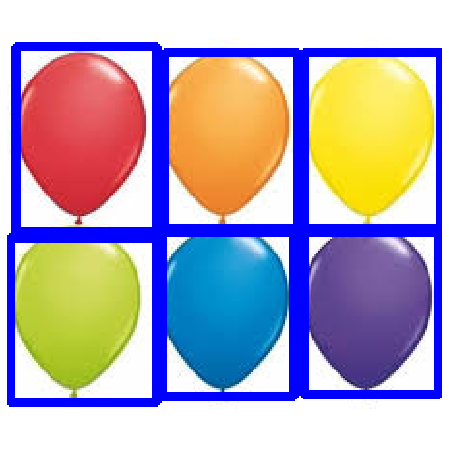

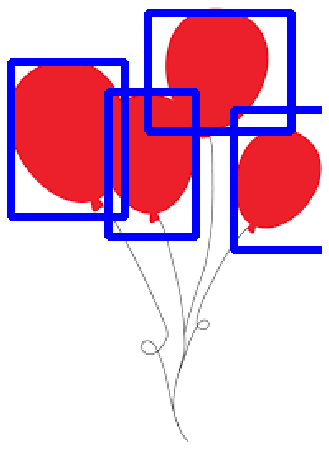

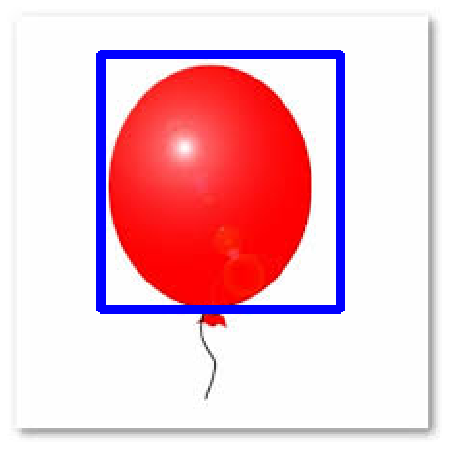

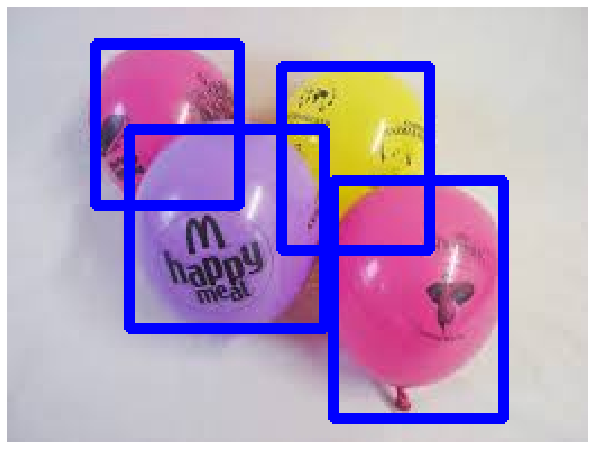

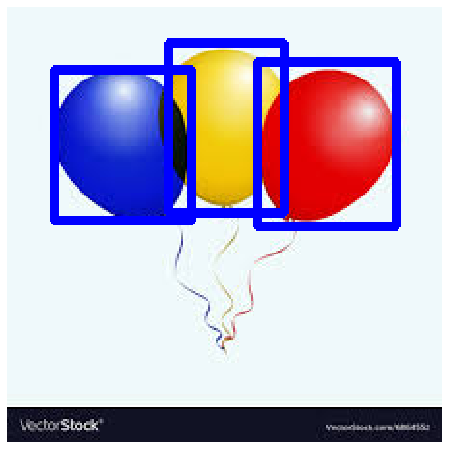

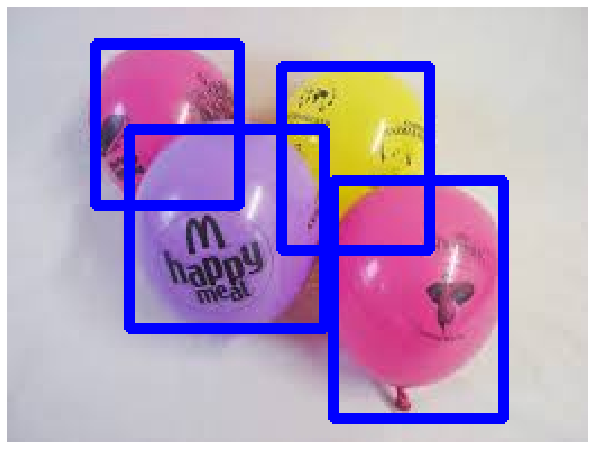

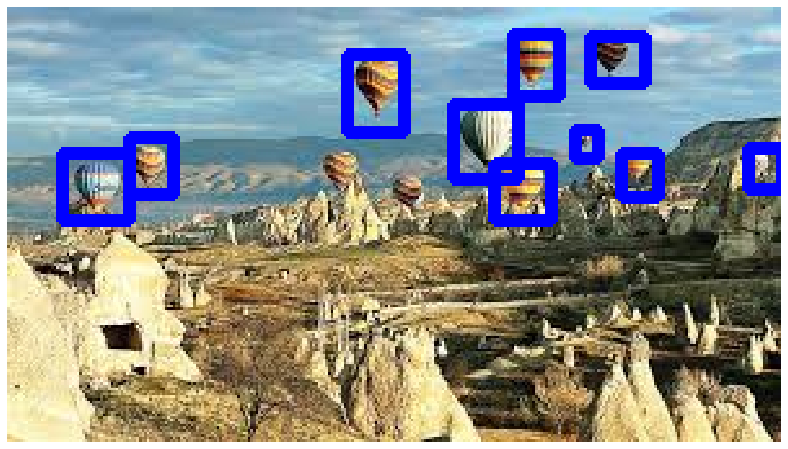

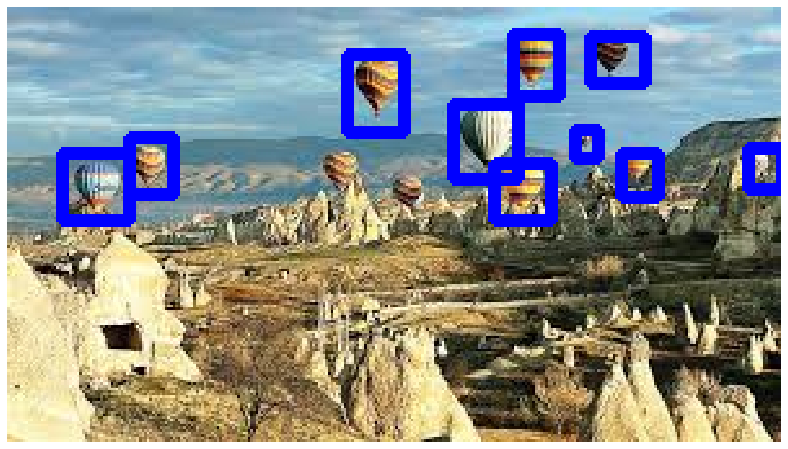

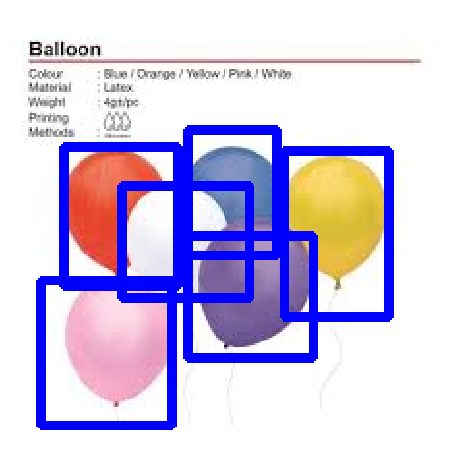

In [61]:
import scipy.misc
from PIL import Image
file_num = 12 #2,5,13,20 #2
#file_nums =[1,15,20,30]

file_nums =[6,7,10,15,16,22,32,36,1,35,40,42,65]
#file_nums =[35,45,50,55,60]
for file_num in file_nums:
    img_path =path +df['#filename'][file_num]
    #print('image_path->',img_path)
    #box_true=make_true_boxes(df,file_num)
    #box_true
    box_true=make_true_boxes(df,file_num)
    image_show(img_path,file_num,df,box_true,True,input_size)

# model predicct

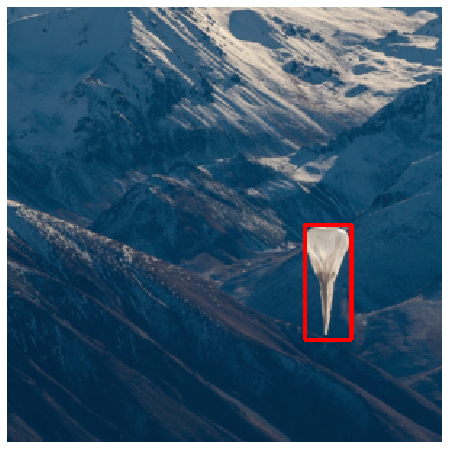

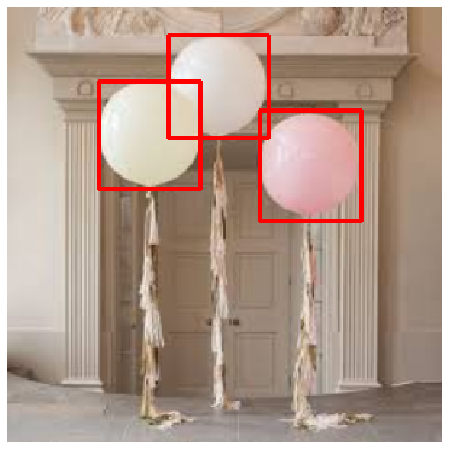

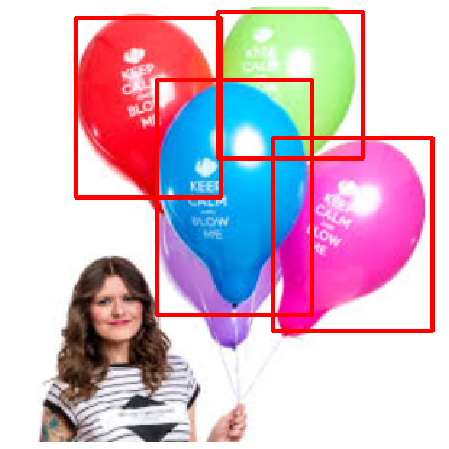

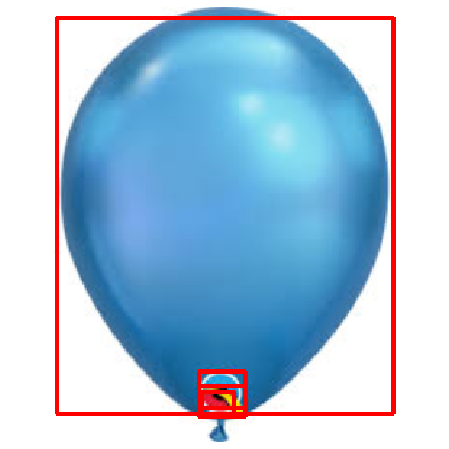

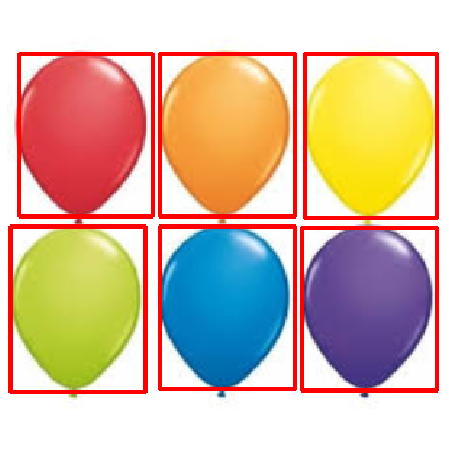

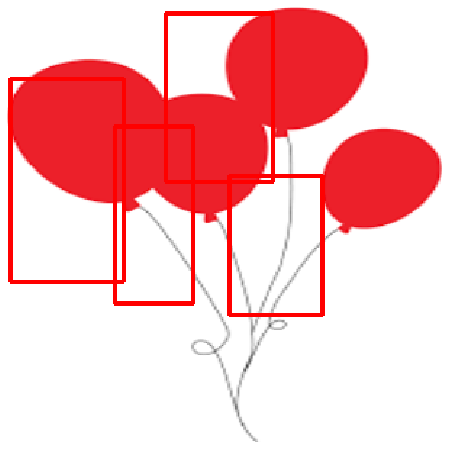

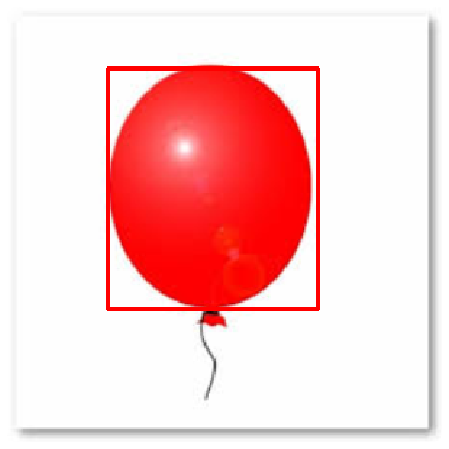

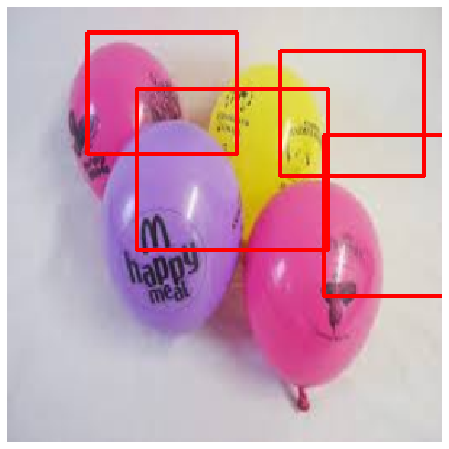

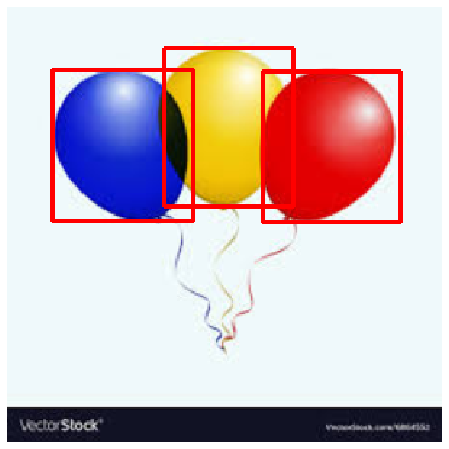

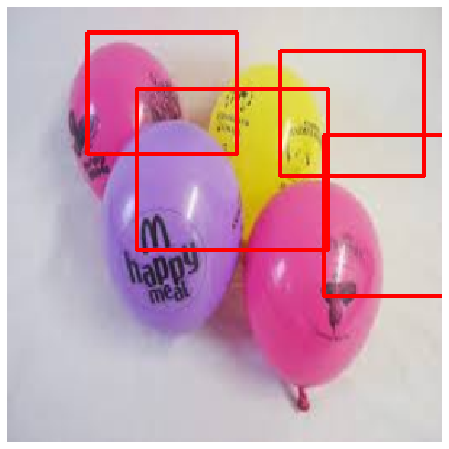

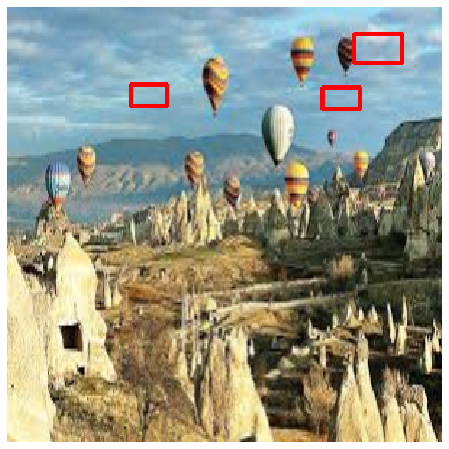

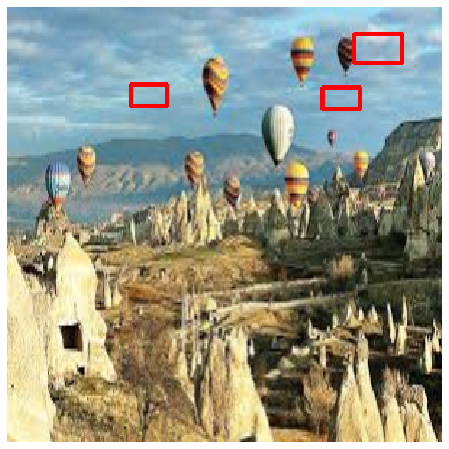

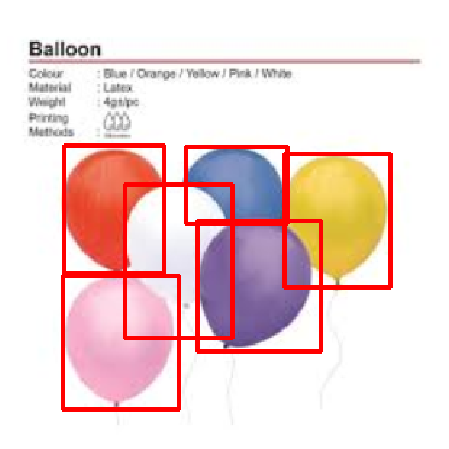

In [62]:
#img_path =path +df['#filename'][file_num]
for file_num in file_nums:
    img_path =path +df['#filename'][file_num]
    #print('image_path->',img_path)
    #print('img_path->',img_path)
    image_arr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_arr /= 255.0

    model =torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    checkpoint = torch.load(weight_path)
    #print('weight_path-?>',weight_path)
    model.load_state_dict(checkpoint['state_dict'])
    epoch = checkpoint['epoch']
    model.cuda()

    new_image_model = FT.to_tensor(np.array(image_arr)).cuda()
    model.eval()
    outputs = model([new_image_model])
    outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]
    confidences = outputs[0]['scores']
    boxes_pred = outputs[0]['boxes']

    threshold = 0.7
    boxes_pred = boxes_pred[confidences > threshold]
    confidences = confidences[confidences > threshold]

    #print(boxes_pred)
    #print(confidences)
    #print(len(boxes_pred))
    image_show(img_path,file_num,df,boxes_pred,False,input_size)